# Neural network for CAN signal prediction

Steering Angle 값을 예측하는 단순 Feedforward network


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

## 데이터 읽어 오기

뉴럴 네트워크에서는 데이터를 잘 준비하는 것이 중요함. 서로 Range가 다른 값들을 효과적으로 학습 시키려면 적절한 scaling과 값 분류가 필요함.

In [2]:
data_path = 'SAS.csv'

can = pd.read_csv(data_path)
can.shape

(3615, 17)

In [3]:
can.head()


,SAS_Angle[Deg],SAS_Speed,CR_Yrs_Yr,CR_Yrs_LatAc[g],ACCEL_REF_ACC[m/s^2],DriverBraking,CR_Mdps_DrvTq,CR_Brk_StkDep_Pc[%],CR_Yrs_LongAc[g],CR_Mdps_StrColTq[Nm],CR_Mdps_StrTq[Nm],CR_Mdps_OutTq,CF_Gway_TSigLHSw,CF_Gway_TSigRHSw,CR_Vcu_AccPedDep_Pc[%],CR_Mcu_VehSpd_Kph[kph],Time[s]
0,8.9,0,0.220,0.041936,0.0,1,-0.06,38,0.035180,-0.062500,-0.06,0.0,0,0,0.0,0,241
1,8.9,0,0.195,0.039897,0.0,1,-0.06,38,0.032504,-0.062500,-0.06,0.0,0,0,0.0,0,242
2,8.9,0,0.260,0.040151,0.0,1,-0.06,38,0.028935,-0.062500,-0.06,0.0,0,0,0.0,0,243
3,8.9,0,0.255,0.043083,0.0,1,-0.06,39,0.031739,-0.054688,-0.06,0.0,0,0,0.0,0,244
4,8.9,0,0.210,0.044995,0.0,1,-0.06,39,0.034033,-0.062500,-0.06,0.0,0,0,0.0,0,245


## 데이터 확인

1초 단위로 샘플링한 차량의 CAN 데이터로 스티어링 각도, 스티어링 토크, Yaw, 가속도, Braking, Accel pedal, 차속, Turn signal 등의 정보를 담고 있음.

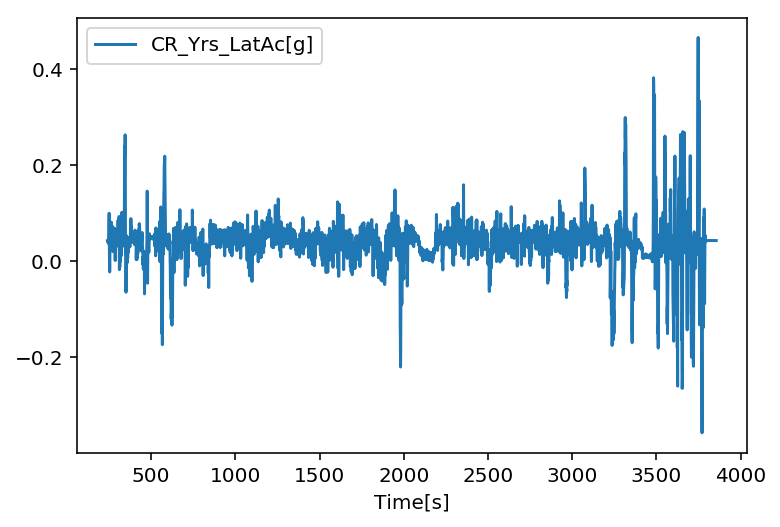

In [4]:
can[:].plot(x='Time[s]', y='CR_Yrs_LatAc[g]')
#can[:].plot(x='Time[s]', y='SAS_Angle[Deg]')

#can[:24*10].plot(x='CR_Vcu_AccPedDep_Pc[%]', y='CR_Vcu_WhlDemTq_Nm[Nm]')

### 더미 변수
Turn signal이나 Brake on 등의 신호는 카테고리를 분류하는 신호값이기 때문에 이진 더미 변수로 변경이 필요하다.
Pandas library의 `get_dummies()` 함수로 쉽게 변환 가능함.

In [5]:
dummy_fields = ['DriverBraking', 'CF_Gway_TSigLHSw', 'CF_Gway_TSigRHSw']
for each in dummy_fields:
    dummies = pd.get_dummies(can[each], prefix=each, drop_first=False)
    can = pd.concat([can, dummies], axis=1)

#fields_to_drop = ['CR_Yrs_Yr', 'ACCEL_REF_ACC[m/s^2]', 'CR_Mdps_StrTq[Nm]', 'CR_Mdps_OutTq', 
#                  'DriverBraking', 'CF_Gway_TSigLHSw', 'CF_Gway_TSigRHSw', 'Time[s]']
fields_to_drop = ['DriverBraking', 'CF_Gway_TSigLHSw', 'CF_Gway_TSigRHSw', 'Time[s]']
data = can.drop(fields_to_drop, axis=1)
data.head()
#type(data)
#data.shape

,SAS_Angle[Deg],SAS_Speed,CR_Yrs_Yr,CR_Yrs_LatAc[g],ACCEL_REF_ACC[m/s^2],CR_Mdps_DrvTq,CR_Brk_StkDep_Pc[%],CR_Yrs_LongAc[g],CR_Mdps_StrColTq[Nm],CR_Mdps_StrTq[Nm],CR_Mdps_OutTq,CR_Vcu_AccPedDep_Pc[%],CR_Mcu_VehSpd_Kph[kph],DriverBraking_0,DriverBraking_1,CF_Gway_TSigLHSw_0,CF_Gway_TSigLHSw_1,CF_Gway_TSigRHSw_0,CF_Gway_TSigRHSw_1
0,8.9,0,0.220,0.041936,0.0,-0.06,38,0.035180,-0.062500,-0.06,0.0,0.0,0,0,1,1,0,1,0
1,8.9,0,0.195,0.039897,0.0,-0.06,38,0.032504,-0.062500,-0.06,0.0,0.0,0,0,1,1,0,1,0
2,8.9,0,0.260,0.040151,0.0,-0.06,38,0.028935,-0.062500,-0.06,0.0,0.0,0,0,1,1,0,1,0
3,8.9,0,0.255,0.043083,0.0,-0.06,39,0.031739,-0.054688,-0.06,0.0,0.0,0,0,1,1,0,1,0
4,8.9,0,0.210,0.044995,0.0,-0.06,39,0.034033,-0.062500,-0.06,0.0,0.0,0,0,1,1,0,1,0


In [6]:
data.shape

(3615, 19)

### Scaling target variables
딥러닝 모델 훈련을 효과적으로 하려면, 각 변수 값들은 정규화 해줘야 함. (값들의 range가 각 각 다르기 때문) 
zero mean 과 standard deviation 1로 정규화 한다.

scaling factor들은 각 각 저장하여 나중에 예측된 값을 원 신호로 복원하는데 사용하도록 한다.

In [7]:
#quant_features = ['SAS_Angle[Deg]', 'SAS_Speed', 'CR_Yrs_LatAc[g]', 'CR_Mdps_DrvTq', 'CR_Brk_StkDep_Pc[%]', 
#                 'CR_Yrs_LongAc[g]', 'CR_Mdps_StrColTq[Nm]','CR_Vcu_AccPedDep_Pc[%]', 'CR_Mcu_VehSpd_Kph[kph]' ]
quant_features = ['SAS_Angle[Deg]', 'SAS_Speed', 'CR_Yrs_LatAc[g]', 'ACCEL_REF_ACC[m/s^2]', 'CR_Mdps_DrvTq', 'CR_Brk_StkDep_Pc[%]', 
                 'CR_Yrs_LongAc[g]', 'CR_Mdps_StrColTq[Nm]','CR_Mdps_StrTq[Nm]', 'CR_Mdps_OutTq', 'CR_Vcu_AccPedDep_Pc[%]', 'CR_Mcu_VehSpd_Kph[kph]' ]

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std   # loc : label을 가지고 row나 column을 access

type(data)
data.head()
print("data_size :",data.shape)

data_size : (3615, 19)


### 데이터를 training(학습,훈련 용), validation set(검증 용), testing(테스트, 시험 용) 으로 나눈다

먼저 데이터를 7:3으로 나누고 30%를 Test set으로 사용한다. 
features 는 딥러닝 모델로 들어가는 input이 되고, target은 모델에서 출력되는 값의 정답이 된다.

In [8]:
# Save data for approximately 30%
test_data = data[-1084:]    # 뒤에서 1084 번째 부터 데이터 끝까지 30%
#print(test_data.shape)
# Now remove the test data from the data set 
data = data[:-1084]         # 처음부터 뒤에서 1084 제외한 데이터까지 70%

# Separate the data into features and targets
target_fields = ['SAS_Angle[Deg]']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
print("test_data", test_data.shape)
print("data", data.shape)

test_data (1084, 19)
data (2531, 19)


나머지 70% 데이터는 Training(훈련) 용 과 Validation(검증) 용으로 나눈다. 이번에는 8:2 비율로 나눔. 
데이터가 time series data 이므로 과거의 흐름을 학습하고 미래의 데이터를 예측하는 형태임.

In [11]:
# 8:2 for training and validation
train_features, train_targets = features[:-506], targets[:-506]
val_features, val_targets = features[-506:], targets[-506:]
print("train_data : ", train_features.shape)
print("validation_data : ", val_features.shape)
#features.shape

train_data :  (2025, 18)
validation_data :  (506, 18)


## 네트워크 구성하기 (딥러닝 모델 생성)

1. 사용한 딥러닝 모델을 생성한다. 
2. forward pass 와 backwards pass 함수를 구현한다.
3. hyperparameter들을 설정한다.(learning rate, hidden unit 개수), training 횟수)

<img src="neural_network.png" width=300px>

여기에서는 간단한 두 개 layer로 구성된 네트워크를 구성한다.(hidden layer 와 output layer). 
hidden layer 에서는 활성함수(activation)로 sigmoid 함수를 사용한다.
output layer 는 한 개의 노드로 구성되며 별도의 활성함수는 사용하지 않는다.$f(x)=x$. 
(backpropagation 할 때 output node의 미분은 그냥 1 이 됨.)


<img src="sigmoid.gif" width=300px>




1. sigmoid 함수를 구현 해서 `__init__` 안에 있는 `self.activation_function` 에 설정
2. `train` method에 forward pass 구현.
3. `train` method에 output error와 backpropagation algorithm 구현
4. `run` method에 forward pass 구현.
  

In [16]:
#############
# Create Neural Network
#############


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### sigmoid function ####
        #self.activation_function = lambda x : 1. / (1. + np.exp(-x))  
        
        ### sigmoid function ####
        def sigmoid(x):
            return 1. / (1. + np.exp(-x))  # sigmoid calculation 
        self.activation_function = sigmoid
                    

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # Implement the forward pass function 
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            # Implement the backproagation function 
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
            
            self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        #### Implement the forward pass ####
       
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer, The activation function is 𝑓(𝑥)=𝑥
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        # Backpropagated error terms
        # output_error_term = error * output function gradient
        output_error_term = error # since the activation function for output is 𝑓(𝑥)=𝑥
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:,None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:,None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass ####
        # Hidden layer 
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs



In [17]:

#########################################################
# Set hyperparameters
##########################################################
iterations = 2000
learning_rate = 0.01
hidden_nodes = 56
output_nodes = 1


In [18]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    #def test_data_path(self):
        # Test that file path to dataset has been unaltered
        #self.assertTrue(data_path.lower() == 'bike-sharing-dataset/SAS.csv')
        
    #def test_data_loaded(self):
        # Test that data frame loaded
        #self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

## 학습 시키기

에러를 최소화 하되 overfitting(과적합) 되지 않도록 학습 시키는 것이 중요하다. 너무 오래 훈련 시키거나 hidden node수가 너무 많으면 Training data에만 최적화 되어 validation data에서 좋은 결과를 얻을 수가 없다. (training loss가 줄어드는 반면 validation loss는 증가 할 수 있음)

Stochastic Gradient Descent (SGD) : 일정 개수의 샘플을 입력으로 넣어 weight를 업데이트 하는 방식으로 빠르고 효율적으로 학습 시킬 수 있다.

### 반복 횟수 결정
training loss와 validation loss가 모두 최소가 되는 지점을 찾는 것이 중요함 

### learning rate 결정
weight update 사이즈 조절. 너무 크면 발산의 우려가 있어 학습이 잘 되지 않는다 보통 0.1 정도 사용함. 잘 학습이 안되면 좀더 낮춰 볼 수 있으나 학습하는데 걸리는 시간이 늘어나게 된다.

### hidden node 수 결정
노드 수가 많을 수록 정확도는 올라가지만, weight최적화가 어렵고 overfitting의 가능성이 높아진다.


In [19]:

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['SAS_Angle[Deg]']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['SAS_Angle[Deg]'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['SAS_Angle[Deg]'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

/home/kzi/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


Progress: 100.0% ... Training loss: 0.003 ... Validation loss: 0.001

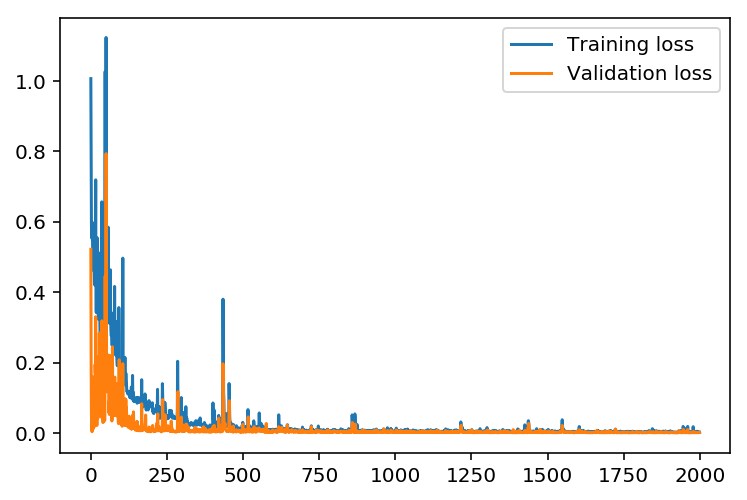

In [20]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 예측 신호값과 실제값 비교

여기에서 앞에서 따로 남겨 두었던 30%의 Test dataset을 사용하여 모델이 예측한 값과 실제 신호값이 얼마나 일치하는지 확인 한다. 
이 30%의 데이터는 이 모델 입장에서는 본 적이 없는 데이터 이다.

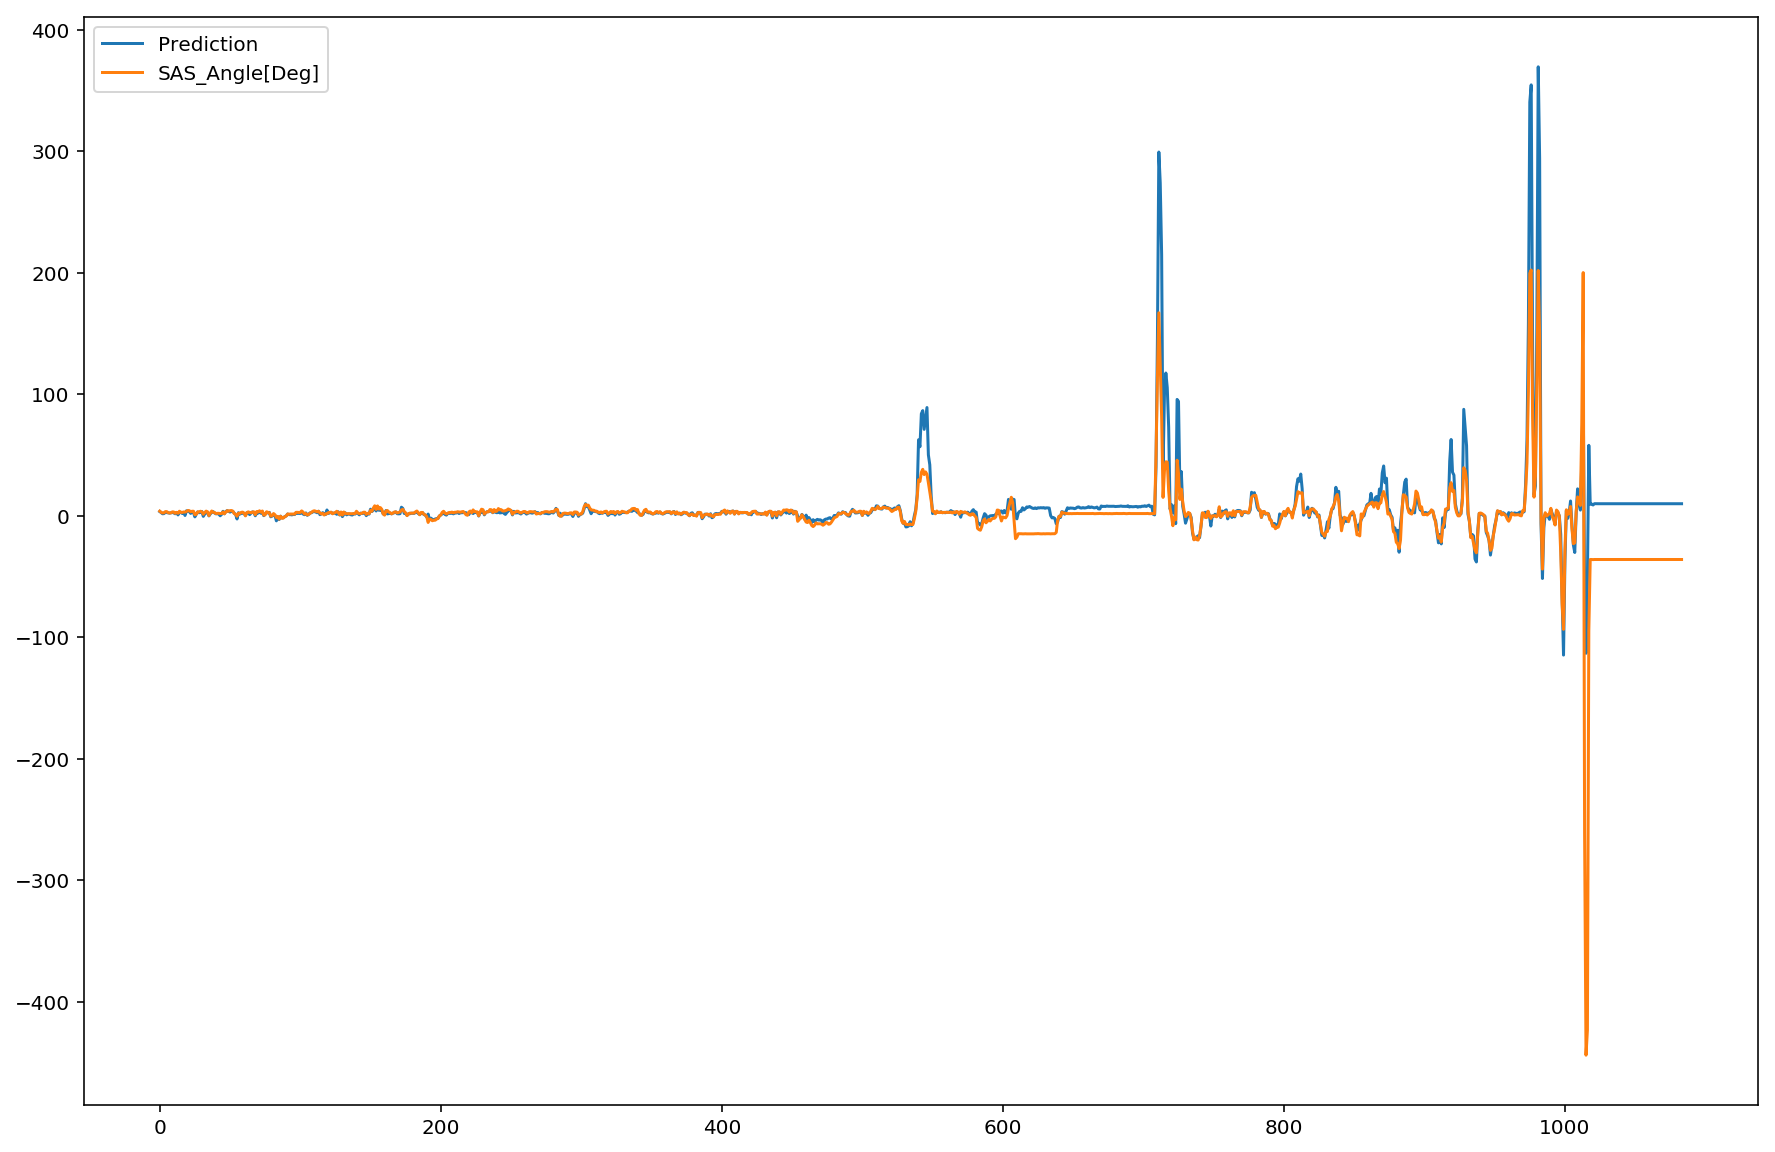

In [21]:
fig, ax = plt.subplots(figsize=(15,10))

mean, std = scaled_features['SAS_Angle[Deg]']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['SAS_Angle[Deg]']*std + mean).values, label='SAS_Angle[Deg]')
#ax.set_xlim(right=len(predictions))
ax.legend()
